Penguin Population Analysis - Palmer Archipelago.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# Dataset
df = pd.read_csv('penguins_size.csv')

print("__Dataset Shape __")
print(df.shape)
print("\n-- Data Types --")
print(df.dtypes)
print("\n-- Statistical Description --")
print(df.describe(include='all'))

__Dataset Shape __
(344, 7)

-- Data Types --
species               object
island                object
culmen_length_mm     float64
culmen_depth_mm      float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
dtype: object

-- Statistical Description --
       species  island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
count      344     344        342.000000       342.000000         342.000000   
unique       3       3               NaN              NaN                NaN   
top     Adelie  Biscoe               NaN              NaN                NaN   
freq       152     168               NaN              NaN                NaN   
mean       NaN     NaN         43.921930        17.151170         200.915205   
std        NaN     NaN          5.459584         1.974793          14.061714   
min        NaN     NaN         32.100000        13.100000         172.000000   
25%        NaN     NaN         39.225000        15.600000         

In [9]:
# Cleaning the sex column artifacts
df['sex'] = df['sex'].replace('.', np.nan)

for species in df['species'].unique():
    cols = ['culmen_length_mm', 'body_mass_g', 'culmen_depth_mm', 'flipper_length_mm']
    for col in cols:
        median_val = df[df['species'] == species][col].median()
        df.loc[(df['species'] == species) & (df[col].isna()), col] = median_val

        # Sex column
        mode_sex = df[df['species'] == species]['sex'].mode()[0]
        df.loc[(df['species'] == species)& (df['sex'].isna()), 'sex'] = mode_sex

    # Outliers Detection
    numeric_cols = ['culmen_length_mm', 'body_mass_g', 'culmen_depth_mm', 'flipper_length_mm']

for col in numeric_cols:
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    outliers_iqr = df[
        (df[col] < Q1 - 1.5 * IQR) | 
        (df[col] > Q3 + 1.5 * IQR)
    ].shape[0]

    # Z-score Method
    z_scores = np.abs(stats.zscore(df[col].dropna()))
    outliers_z = (z_scores > 3).sum()

    print(f"{col} -> IQR Outliers: {outliers_iqr}, Z-score Outliers: {outliers_z}")
        

culmen_length_mm -> IQR Outliers: 0, Z-score Outliers: 0
body_mass_g -> IQR Outliers: 0, Z-score Outliers: 0
culmen_depth_mm -> IQR Outliers: 0, Z-score Outliers: 0
flipper_length_mm -> IQR Outliers: 0, Z-score Outliers: 0


In [10]:
# Create Derived Features
df['bill_ratio'] = df['culmen_length_mm'] / df['culmen_depth_mm']
# BMI proxy
df['body_mass_index'] = (df['body_mass_g']/1000) / ((df['flipper_length_mm']/1000)**2)
df['size_category'] = pd.cut(df['body_mass_g'], 3, labels=['Small', 'Medium', 'Large'])

# Summary Statistics by Species and Island
species_summary = df.groupby('species')[numeric_cols + ['bill_ratio']].agg(['mean', 'std', 'median'])
island_summary = df.groupby('island')[numeric_cols + ['bill_ratio']].agg(['mean', 'std', 'median'])

print("\n-- Summary by Species --")
print(species_summary)


-- Summary by Species --
          culmen_length_mm                   body_mass_g                      \
                      mean       std median         mean         std  median   
species                                                                        
Adelie           38.791447  2.654571  38.80  3700.657895  457.045176  3700.0   
Chinstrap        48.833824  3.339256  49.55  3733.088235  384.335081  3700.0   
Gentoo           47.503226  3.069359  47.30  5075.403226  502.109208  5000.0   

          culmen_depth_mm                  flipper_length_mm                   \
                     mean       std median              mean       std median   
species                                                                         
Adelie          18.346711  1.212622  18.40        189.953947  6.517769  190.0   
Chinstrap       18.420588  1.135395  18.45        195.823529  7.131894  196.0   
Gentoo          14.982258  0.977224  15.00        217.177419  6.459440  216.0   

      


-- Normality Test (p > 0.05 means Normal) --
culmen_length_mm: p-value = 0.00001
body_mass_g: p-value = 0.00000
culmen_depth_mm: p-value = 0.00000
flipper_length_mm: p-value = 0.00000


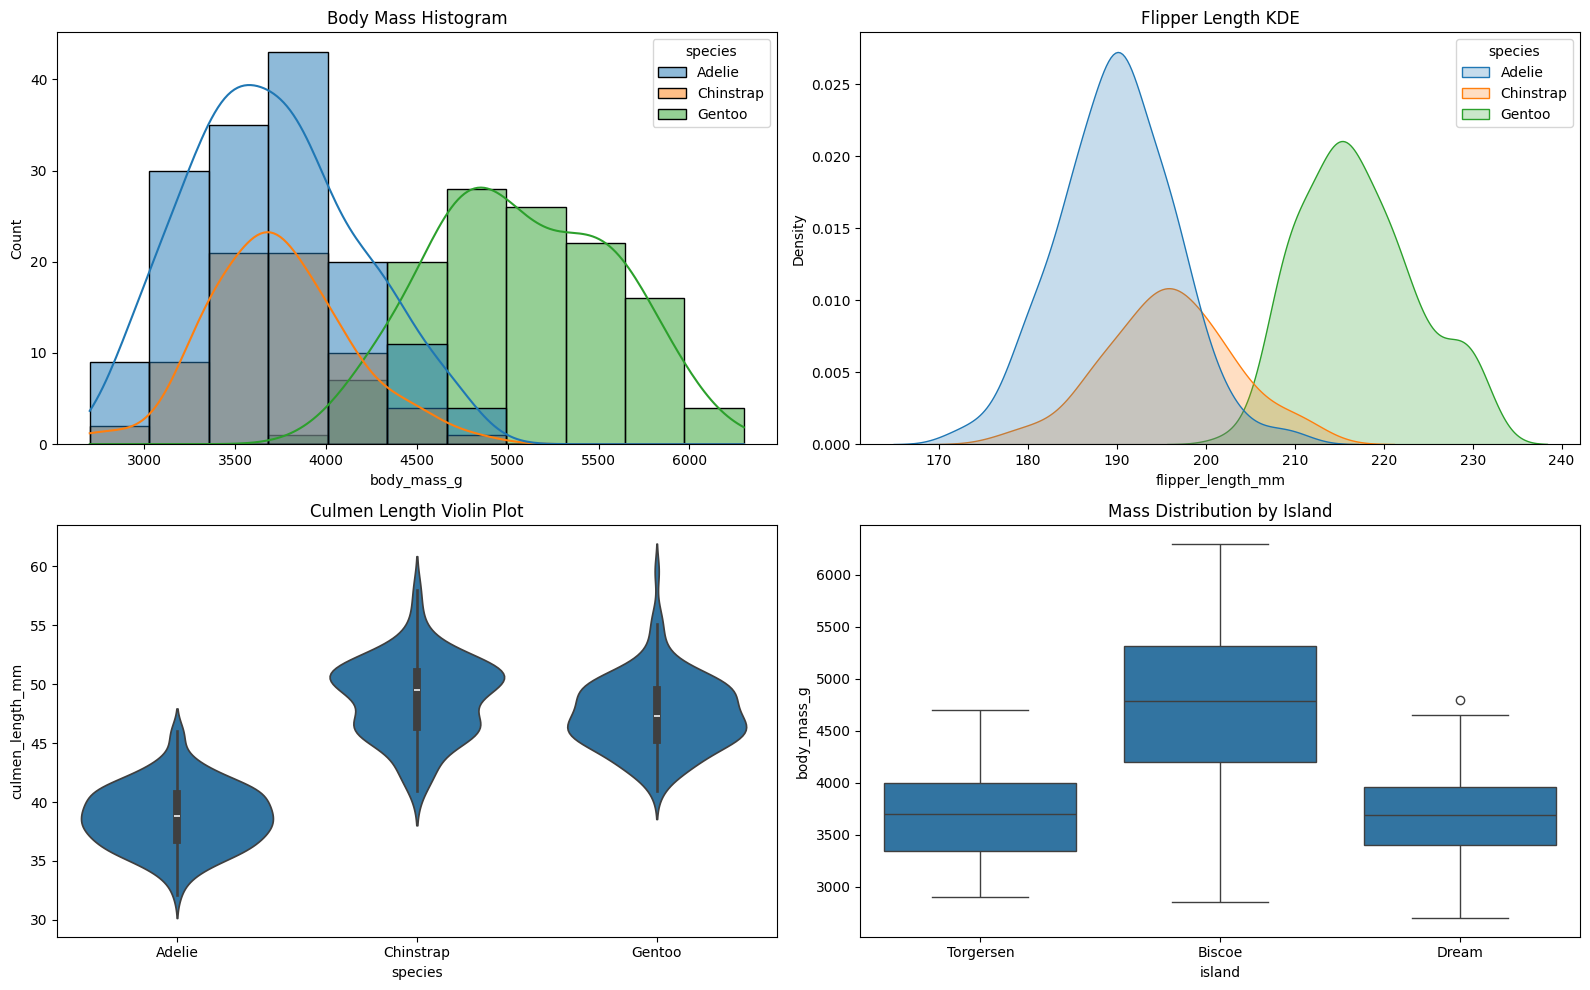


-- Skewness & Kurtosis --
          culmen_length_mm  body_mass_g  culmen_depth_mm  flipper_length_mm
skew              0.054050     0.467771        -0.141926           0.343675
kurtosis         -0.876466    -0.723129        -0.910300          -0.989498


In [15]:
# Shapiro Wilk Test for Normality
print("\n-- Normality Test (p > 0.05 means Normal) --")
for col in numeric_cols:
    stat, p = stats.shapiro(df[col])
    print(f"{col}: p-value = {p:.5f}")

# Distribution Visualizations
plt.figure(figsize=(16, 10))
plt.subplot(2, 2, 1); sns.histplot(data=df, x='body_mass_g', hue='species', kde=True); plt.title('Body Mass Histogram')
plt.subplot(2, 2, 2); sns.kdeplot(data=df, x='flipper_length_mm', hue='species', fill=True); plt.title('Flipper Length KDE')
plt.subplot(2, 2, 3); sns.violinplot(data=df, x='species', y='culmen_length_mm'); plt.title('Culmen Length Violin Plot')
plt.subplot(2, 2, 4); sns.boxplot(data=df, x='island', y='body_mass_g'); plt.title('Mass Distribution by Island')
plt.tight_layout();
plt.show()

# Skewness and Kurtosis
print("\n-- Skewness & Kurtosis --")
print(df[numeric_cols].agg(['skew', 'kurtosis']))

In [17]:
# Confidence Intervals (95%)
def get_ci(data):
    n = len(data)
    m, se = np.mean(data), stats.sem(data)
    h = se * stats.t.ppf((1 + 0.95) / 2., n-1)
    return f"{m:.2f} +_ {h:.2f}"

ci_table = df.groupby('species')['body_mass_g'].apply(get_ci)
print("\n-- 95% Confidence Intervals for Body Mass --")
print(ci_table)

# ANOVA for Body Mass
f_stat, p_val = stats.f_oneway(
    df[df['species']=='Adelie']['body_mass_g'],
    df[df['species']=='Chinstrap']['body_mass_g'],
    df[df['species']=='Gentoo']['body_mass_g']
)
print(f"\nANOVA Result: F={f_stat:.2f}, p={p_val:.2e}")

# T-test for Bill Dimesions (Male vs Female)
males = df[df['sex']=='MALE']['culmen_length_mm']
females = df[df['sex']=='FEMALE']['culmen_length_mm']
t_stat, p_t = stats.ttest_ind(males, females)
print(f"T-test (Bill Length Male vs Female): p={p_t:.2e}")


-- 95% Confidence Intervals for Body Mass --
species
Adelie       3700.66 +_ 73.25
Chinstrap    3733.09 +_ 93.03
Gentoo       5075.40 +_ 89.25
Name: body_mass_g, dtype: object

ANOVA Result: F=347.70, p=4.86e-83
T-test (Bill Length Male vs Female): p=7.18e-12



Correlation (Flipper vs Mass): 0.8717


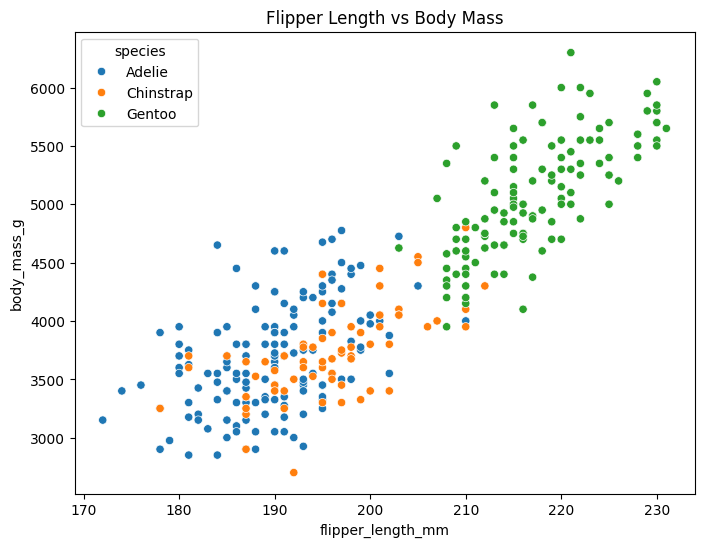


-- Speicies Count per Island --
species    Adelie  Chinstrap  Gentoo
island                              
Biscoe         44          0     124
Dream          56         68       0
Torgersen      52          0       0
Cohen's d (Gentoo vs Others): 2.9641


In [18]:
# Correlation between flipper length and body mass
correlation = df['flipper_length_mm'].corr(df['body_mass_g'])
print(f"\nCorrelation (Flipper vs Mass): {correlation:.4f}")

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='flipper_length_mm', y='body_mass_g', hue='species')
plt.title('Flipper Length vs Body Mass')
plt.show()

# Island location Relationships
island_cross = pd.crosstab(df['island'], df['species'])
print("\n-- Speicies Count per Island --")
print(island_cross)

def cohen_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std

gentoo_mass = df[df['species'] == 'Gentoo']['body_mass_g']
other_mass = df[df['species'] != 'Gentoo']['body_mass_g']
print(f"Cohen's d (Gentoo vs Others): {cohen_d(gentoo_mass, other_mass):.4f}")

In [19]:
# final export
df.to_csv('penguins_final_analysis.csv', index=False)